# Neural Contextual Bandits with UCB-based Exploration
Notation:

| Notation                 | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| $K$                      | number of arms                                               |
| $T$                      | number of total rounds                                       |
| $t$                      | index of round                                               |
| $x_{t,a}$                | $x_{t,a}\in\mathbb{R}^d$, $a\in [K]$, it is the context, the context consists of $K$ feature vectors $\{x_{t,a}\in\mathbb{R}^d|a\in[K]\}$ |
| $a_t$                    | after observes the context, the agent select an action $a_t$ in round t |
| $r_{t,a_t}$              | the reward after the agent select action $a_t$               |
| $h$                      | we assume that $r_{t,a_t}=h(x_{t,a_t})+\xi_t$, h is an unknown function satisfying $0\le h(x)\le 1$ for any x |
| $\xi_t$                  | $\xi_t$ is v-sub-Gaussian noise conditioned on $x_{1,a_1},\cdots,x_{t-1,a_{t-1}}$, satisfying $\mathbb{E}\xi_t=0$ |
| $L$                      | the depth of neural network                                  |
| $m$                      | number of neural in each layer of network                    |
| $\sigma(x)$              | we define $\sigma(x)=\max\{x,0\}$                            |
| $W_1,\cdots,W_{L-1},W_L$ | the weight in neural network. $W_1\in\mathbb{R}^{m\times d}$, $W_i\in\mathbb{R}^{m\times m}$, $2\le i\le L-1$, $W_L\in\mathbb{R}^{m\times 1}$ |
| $\theta$                 | $\theta=[vec(W_1)^T,\cdots,vec(W_l)^T]\in\mathbb{R}^p$, $p=m+md+m^2(L-1)$ |
| $f(x;\theta)$            | we define $f(x;\theta)=\sqrt{m}W_L\sigma(W_{l-1}\sigma(\cdots\sigma(W_1x)))$ |


<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

Initialization of parameters:

<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Initialization2.png" style="zoom:80%" />

UCB algorithm:

<img src="./Figure/NeuralUCB_Algorithm1.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Algorithm2.png" style="zoom:80%" />

we set $\mathcal{L}(\theta) = \sum_{i=1}^t\frac{(f(x_{i,a_i};\theta)-r_{i,a_i})^2}{2}+\frac{m\lambda||\theta-\theta^{(0)}||^2_2}{2}$

Then the gradient would be
$$
\nabla\mathcal{L}(\theta) = \sum_{i=1}^t(f(x_{i,a_i};\theta)-r_{i,a_i})\nabla f(x_{i,a_i};\theta) + m\lambda(\theta-\theta^{(0)})
$$

Forawar Algorithm of Neural Network
$$
\begin{align}
X_0 &= X\\
X_1 &=\sigma(W_1X_0)\\
X_2 &=\sigma(W_2X_1)\\
\cdots\\
X_{L-1}&=\sigma(W_{L-1}X_{L-2})\\
X_{L} &=W_L X_{L-1}
\end{align}
$$
$f(X) = X_L$

Backward Propagation
$$
\begin{align}
\nabla_{X_L}f &= 1\\
\nabla_{W_L}f &= X_{L-1}\\
\nabla_{X_{L-1}}f &= W_{L}\\
\\
\nabla_{W_{L-1}}f &= \nabla_{W_{L-1}}f(X_{L-1}(W_{L-1}, X_{L-2}), W_L)=\nabla_{X_{L-1}}f \cdot \nabla_{W_{L-1}}X_{L-1}(W_{L-1}, X_{L-2})\\
\nabla_{X_{L-2}}f &= \nabla_{X_{L-2}}f(X_{L-1}(W_{L-1}, X_{L-2}), W_L)=\nabla_{X_{L-1}}f \cdot \nabla_{X_{L-2}}X_{L-1}(W_{L-1}, X_{L-2})\\
\\
\nabla_{W_{L-2}}f &= \nabla_{W_{L-2}}f(X_{L-2}(W_{L-2}, X_{L-3}), W_L,W_{L-1})=\nabla_{X_{L-2}}f \cdot \nabla_{W_{L-2}}X_{L-2}(W_{L-2}, X_{L-3})\\
\nabla_{X_{L-3}}f &= \nabla_{X_{L-3}}f(X_{L-2}(W_{L-2}, X_{L-3}), W_L,W_{L-1})=\nabla_{X_{L-2}}f \cdot \nabla_{X_{L-3}}X_{L-2}(W_{L-2}, X_{L-3})\\
\cdots\\
\nabla_{W_{l}}f &= \nabla_{W_{l}}f(X_{l}(W_{l}, X_{l-1}), W_L,W_{L-1},\cdots,W_{l+1})=\nabla_{X_{l}}f \cdot \nabla_{W_{l}}X_{l}(W_{l}, X_{l-1})\\
\nabla_{X_{l-1}}f &= \nabla_{X_{l-1}}f(X_{l}(W_{l}, X_{l-1}), W_L,W_{L-1},\cdots,W_{l+1})=\nabla_{X_{l}}f \cdot \nabla_{X_{l-1}}X_{l}(W_{l}, X_{l-1})\\
\cdots\\
\nabla_{W_{1}}f &= \nabla_{W_{1}}f(X_{1}(W_{1}, X_{0}), W_L,W_{L-1},\cdots,W_{2})=\nabla_{X_{1}}f \cdot \nabla_{W_{1}}X_{1}(W_{1}, X_{0})\\
\nabla_{X_{0}}f &= \nabla_{X_{0}}f(X_{1}(W_{1}, X_{0}), W_L,W_{L-1},\cdots,W_{2})=\nabla_{X_{1}}f \cdot \nabla_{X_{0}}X_{1}(W_{1}, X_{0})\\
\end{align}
$$

$\nabla_{W_{l}}f$ is a matrix, to be specific, $\nabla_{W_{l}}f=\left[\begin{matrix}\frac{\partial f}{\partial w^{(l)}_{11}}&\cdots &\frac{\partial f}{\partial w^{(l)}_{1m}}\\ \vdots&& \vdots\\ \frac{\partial f}{\partial w^{(l)}_{m1}}&\cdots &\frac{\partial f}{\partial w^{(l)}_{mm}}\end{matrix}\right]$

$$
\begin{align}
\left[\begin{matrix}\frac{\partial f}{\partial w^{(l)}_{11}}&\cdots &\frac{\partial f}{\partial w^{(l)}_{1m}}\\ \vdots&& \vdots\\ \frac{\partial f}{\partial w^{(l)}_{m1}}&\cdots &\frac{\partial f}{\partial w^{(l)}_{mm}}\end{matrix}\right]=&
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l)}_{1}} \frac{\partial x^{(l)}_{1}}{\partial w^{(l)}_{11}}&\cdots &\frac{\partial f}{\partial x^{(l)}_{1}}\frac{\partial x^{(l)}_{1}}{\partial w^{(l)}_{1m}}\\ \vdots&& \vdots\\ \frac{\partial f}{\partial x^{(l)}_{m}}\frac{\partial x^{(l)}_{m}}{\partial w^{(l)}_{m1}}&\cdots &\frac{\partial f}{\partial x^{(l)}_{m}}\frac{\partial x^{(l)}_{m}}{\partial w^{(l)}_{mm}}\end{matrix}\right]\\
=&
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l)}_{1}} \mathbb{1}_{\sigma(w^{(l)}_{11}x^{(l-1)}_1+w^{(l)}_{12}x^{(l-1)}_2+\cdots+w^{(l)}_{1m}x^{(l-1)}_m)>0} x^{(l-1)}_{1}&\cdots &\frac{\partial f}{\partial x^{(l)}_{1}}\mathbb{1}_{\sigma(w^{(l)}_{11}x^{(l-1)}_1+w^{(l)}_{12}x^{(l-1)}_2+\cdots+w^{(l)}_{1m}x^{(l-1)}_m)>0} x^{(l-1)}_{m}\\ \vdots&& \vdots\\ \frac{\partial f}{\partial x^{(l)}_{m}}\mathbb{1}_{\sigma(w^{(l)}_{m1}x^{(l-1)}_1+w^{(l)}_{m2}x^{(l-1)}_2+\cdots+w^{(l)}_{mm}x^{(l-1)}_m)>0} x^{(l-1)}_{1}&\cdots &\frac{\partial f}{\partial x^{(l)}_{m}}\mathbb{1}_{\sigma(w^{(l)}_{m1}x^{(l-1)}_1+w^{(l)}_{m2}x^{(l-1)}_2+\cdots+w^{(l)}_{mm}x^{(l-1)}_m)>0} x^{(l-1)}_{m}\end{matrix}\right]\\
\end{align}
$$

$\nabla_{X_{l-1}}f$ is a vector, to be specific, $\nabla_{X_{l-1}}f=\left[\begin{matrix}\frac{\partial f}{\partial x^{(l-1)}_{1}}\\ \vdots\\ \frac{\partial f}{\partial x^{(l-1)}_{m}}\end{matrix}\right]$
$$
\begin{align}
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l-1)}_{1}}\\ \vdots\\ \frac{\partial f}{\partial x^{(l-1)}_{m}}\end{matrix}\right]=&
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l)}_{1}}\frac{\partial x^{(l)}_1}{\partial x^{(l-1)}_1}+\frac{\partial f}{\partial x^{(l)}_{2}}\frac{\partial x^{(l)}_{2}}{\partial x^{(l-1)}_{1}}+\cdots+\frac{\partial f}{\partial x^{(l)}_{m}}\frac{\partial x^{(l)}_{m}}{\partial x^{(l-1)}_{1}}\\ \vdots\\ \frac{\partial f}{\partial x^{(l)}_{1}}\frac{\partial x^{(l)}_{1}}{\partial x^{(l-1)}_{m}}+\frac{\partial f}{\partial x^{(l)}_{2}}\frac{\partial x^{(l)}_{2}}{\partial x^{(l-1)}_{m}}+\cdots+\frac{\partial f}{\partial x^{(l)}_{m}}\frac{\partial x^{(l)}_{m}}{\partial x^{(l-1)}_{m}}\end{matrix}\right]\\
=&
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l)}_{1}}\mathbb{1}_{\sigma(w^{(l)}_{11}x^{(l-1)}_1+w^{(l)}_{12}x^{(l-1)}_2+\cdots+w^{(l)}_{1m}x^{(l-1)}_m)>0}w^{(l)}_{11}+\frac{\partial f}{\partial x^{(l)}_{2}}\mathbb{1}_{\sigma(w^{(l)}_{21}x^{(l-1)}_1+w^{(l)}_{22}x^{(l-1)}_2+\cdots+w^{(l)}_{2m}x^{(l-1)}_m)>0}w^{(l)}_{21}+\cdots+\frac{\partial f}{\partial x^{(l)}_{m}}\mathbb{1}_{\sigma(w^{(l)}_{m1}x^{(l-1)}_1+w^{(l)}_{m2}x^{(l-1)}_2+\cdots+w^{(l)}_{mm}x^{(l-1)}_m)>0}w^{(l)}_{m1}\\ 
\vdots\\ 
\frac{\partial f}{\partial x^{(l)}_{1}}\mathbb{1}_{\sigma(w^{(l)}_{11}x^{(l-1)}_1+w^{(l)}_{12}x^{(l-1)}_2+\cdots+w^{(l)}_{1m}x^{(l-1)}_m)>0}w^{(l)}_{1m}+\frac{\partial f}{\partial x^{(l)}_{2}}\mathbb{1}_{\sigma(w^{(l)}_{21}x^{(l-1)}_1+w^{(l)}_{22}x^{(l-1)}_2+\cdots+w^{(l)}_{2m}x^{(l-1)}_m)>0}w^{(l)}_{2m}+\cdots+\frac{\partial f}{\partial x^{(l)}_{m}}\mathbb{1}_{\sigma(w^{(l)}_{m1}x^{(l-1)}_1+w^{(l)}_{m2}x^{(l-1)}_2+\cdots+w^{(l)}_{mm}x^{(l-1)}_m)>0}w^{(l)}_{mm}\end{matrix}\right ]\\
=&\left[\begin{matrix}w^{(l)}_{11}&\cdots& w^{(l)}_{1m}\\ \vdots&&\vdots\\ w^{(l)}_{m1}&\cdots& w^{(l)}_{mm}\end{matrix}\right]^T
\left[\begin{matrix}\frac{\partial f}{\partial x^{(l)}_{1}}\mathbb{1}_{\sigma(w^{(l)}_{11}x^{(l-1)}_1+w^{(l)}_{12}x^{(l-1)}_2+\cdots+w^{(l)}_{1m}x^{(l-1)}_m)>0}\\ \vdots\\ \frac{\partial f}{\partial x^{(l)}_{m}}\mathbb{1}_{\sigma(w^{(l)}_{m1}x^{(l-1)}_1+w^{(l)}_{m2}x^{(l-1)}_2+\cdots+w^{(l)}_{mm}x^{(l-1)}_m)>0}\end{matrix}\right]\\
\end{align}
$$


 We assume the reward follows reward = context^T * A^T * A * context + \xi
 
 $\xi$ is a random variable following standard normal distribution N(0, 1)
 
 A is d\*d matrix, randomly generated from N(0, 1)
 
 We assume the context is independent from the action and round index. 
 
 Given action a and round index t, the context is randomly sample from a unit ball in dimension d

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy
from GameSetting import *
from NeuralNetworkRelatedFunction import *

In [2]:
class BestAgent:
    def __init__(self, K, T, d):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        expected_reward = np.zeros(K)
        for kk in range(0, K):
            context = context_list[:, kk]
            expected_reward[kk] = context.transpose().dot(A.transpose().dot(A)).dot(context)
        ind = np.argmax(expected_reward, axis=None)
        self.history_context[:, self.t] = context_list[:, ind]
        self.history_action[self.t] = ind
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1
        
    def GetHistoryReward(self):
        return self.history_reward
    
    def GetHistoryAction(self):
        return self.history_action
    
    def GetHistoryContext(self):
        return self.history_context

In [3]:
class UniformAgent:
    def __init__(self, K, T, d):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        ind = np.random.randint(0, high = K) # we just uniformly choose an action
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1
        
    def GetHistoryReward(self):
        return self.history_reward
    
    def GetHistoryAction(self):
        return self.history_action
    
    def GetHistoryContext(self):
        return self.history_context

In [4]:
class NeuralAgent:
    def __init__(self, K, T, d, L = 2, m = 20, gamma_t = 0.01, v = 0.1, lambda_ = 0.01, delta = 0.01, S = 0.01, eta = 0.001, frequency = 50, batchsize = None):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        
        self.L = L
        self.m = m
        self.gamma_t = gamma_t
        self.v = v
        self.lambda_ = lambda_
        self.delta = delta
        self.S = S
        self.eta = eta
        self.frequency = frequency # we train the network after frequency, e.g. per 50 round
        self.batchsize = batchsize
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.predicted_reward = np.zeros(T)
        self.predicted_reward_upperbound = np.zeros(T)
        self.history_context = np.zeros((d, T))
        
        # initialize the value of parameter
        np.random.seed(12345)
        self.theta_0 = {}
        W = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(m/2)))
        w = np.random.normal(loc = 0, scale = 2 / m, size=(1, int(m/2)))
        for key in range(1, L + 1):
            if key == 1:
                # this paper doesn't present the initialization of w1
                # in its setting, d = m, then he let theta_0["w1"]=[W,0;0,W]
                # but in fact d might not equal to m
                tempW = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(d/2)))
                self.theta_0["w1"] = np.zeros((m, d))
                self.theta_0["w1"][0:int(m/2), 0:int(d/2)] = tempW
                self.theta_0["w1"][int(m/2):, int(d/2):] = tempW
            elif 2 <= key and key <= L - 1:
                self.theta_0["w" + str(key)] = np.zeros((m, m))
                self.theta_0["w" + str(key)][0:int(m/2), 0:int(m/2)] = W
                self.theta_0["w" + str(key)][int(m/2):, int(m/2):] = W
            else:
                self.theta_0["w" + str(key)] = np.concatenate([w, -w], axis = 1)
                
        self.p = m + m * d + m * m * (L - 2)
        self.params = deepcopy(self.theta_0)
        self.Z_t_minus1 = lambda_ * np.eye(self.p)
        self.params_history = {}
        self.grad_history = {}
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        U_t_a = np.zeros(K) # the upper bound of K actions
        predict_reward = np.zeros(K)
        for a in range(1, K + 1):
            predict_reward[a - 1] = NeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)['x' + str(self.L)][0]
            grad_parameter = GradientNeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)
            grad_parameter = FlattenDict(grad_parameter, self.L)
            Z_t_minus1_inverse = np.linalg.inv(self.Z_t_minus1)
            U_t_a[a - 1] = predict_reward[a - 1] +\
                           self.gamma_t * np.sqrt(grad_parameter.dot(Z_t_minus1_inverse).dot(grad_parameter)/self.m)
        ind = np.argmax(U_t_a, axis=None)
        self.predicted_reward[self.t] = predict_reward[ind]
        self.predicted_reward_upperbound[self.t] = U_t_a[ind]
        self.history_action[self.t] = ind
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
#         print("round {:d}".format(self.t))
        self.history_reward[self.t] = reward
        ind = self.history_action[self.t]
        context = self.history_context[:, self.t]
        
        # compute Z_t_minus1
        grad_parameter = GradientNeuralNetwork(context, self.params, self.L, self.m)
        grad_parameter = FlattenDict(grad_parameter, self.L)
        grad_parameter = np.expand_dims(grad_parameter, axis = 1)
        self.Z_t_minus1 = self.Z_t_minus1 + grad_parameter.dot(grad_parameter.transpose()) / self.m

        # train neural network
        if self.t % self.frequency == 0 and self.t > 0:
            J = self.t
        else:
            J = 0
            
        if self.batchsize == None:
            trainindex = range(0, self.t + 1)
        else:
            if self.batchsize > self.t + 1:
                trainindex = range(0, self.t + 1)
            else:
                trainindex = random.sample(range(0, self.t + 1), self.batchsize)
                
        grad_loss = {}
        for j in range(J):
            
            grad_loss = GradientLossFunction(self.history_context[:, trainindex],# we had not update self.t yet, so here we must +1
                                             self.params, 
                                             self.L, 
                                             self.m, 
                                             self.history_reward[trainindex], 
                                             self.theta_0, 
                                             self.lambda_)
#             if j < 10:
#                 eta = 1e-4
#             else:
#                 eta = self.eta
            eta = self.eta
            for key in self.params.keys():
                self.params[key] = self.params[key] - eta * grad_loss[key]
            loss = LossFunction(self.history_context[:, trainindex],
                            self.params, 
                            self.L, 
                            self.m,
                            self.history_reward[trainindex],
                            self.theta_0,
                            self.lambda_)
#             print("j {:d}, loss {:4f}".format(j, loss))
        
        print("round {:d}, predicted reward {:4f},predicted upper bound {:4f},actual reward {:4f}".format(self.t,
                                                                                                          self.predicted_reward[self.t], 
                                                                                                          self.predicted_reward_upperbound[self.t], 
                                                                                                          reward))

        self.params_history[self.t] = deepcopy(self.params)
        self.grad_history[self.t] = deepcopy(grad_loss)
        
        self.t = self.t + 1
        
    def GetHistoryReward(self):
        return self.history_reward
    
    def GetHistoryAction(self):
        return self.history_action
    
    def GetHistoryContext(self):
        return self.history_context

In [5]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 5000 # Total number of periods
d = 20 # the dimension of context
A = np.random.normal(loc=0, scale=1, size=(d, d))

In [6]:
# Neural UCB
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 20 
# we fix gamma in each round, according to the description of section 3.1
gamma_t = 0.01 #{0.01, 0.1, 1, 10}
v = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
delta = 0.01 #{0.01, 0.1, 1}
S = 0.01 #{0.01, 0.1, 1, 10}
eta = 1e-4 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 500
# we set J equal to round index t

neuralagent = NeuralAgent(K, T, d, L, m, gamma_t, v, lambda_, delta, S, eta, frequency, batchsize)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = neuralagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    neuralagent.Update(reward)

round 0, predicted reward 0.156496,predicted upper bound 0.163969,actual reward 26.866324
round 1, predicted reward 0.152098,predicted upper bound 0.157251,actual reward 21.779967
round 2, predicted reward 0.223601,predicted upper bound 0.229045,actual reward 22.502430
round 3, predicted reward 0.350837,predicted upper bound 0.356987,actual reward 23.820496
round 4, predicted reward 0.292728,predicted upper bound 0.296934,actual reward 23.628268
round 5, predicted reward 0.163629,predicted upper bound 0.168596,actual reward 24.395122
round 6, predicted reward 0.150042,predicted upper bound 0.153091,actual reward 26.479825
round 7, predicted reward 0.282388,predicted upper bound 0.287587,actual reward 16.411790
round 8, predicted reward 0.009460,predicted upper bound 0.014848,actual reward 26.086504
round 9, predicted reward 0.106620,predicted upper bound 0.111166,actual reward 22.741131
round 10, predicted reward 0.343633,predicted upper bound 0.348210,actual reward 18.129200
round 11,

round 90, predicted reward 17.705822,predicted upper bound 17.726968,actual reward 12.612084
round 91, predicted reward 16.046766,predicted upper bound 16.071448,actual reward 20.233196
round 92, predicted reward 14.144616,predicted upper bound 14.164875,actual reward 27.889139
round 93, predicted reward 16.121896,predicted upper bound 16.145989,actual reward 30.610312
round 94, predicted reward 15.225252,predicted upper bound 15.248123,actual reward 22.012892
round 95, predicted reward 16.355666,predicted upper bound 16.380269,actual reward 23.974887
round 96, predicted reward 8.217883,predicted upper bound 8.240996,actual reward 17.748972
round 97, predicted reward 26.009223,predicted upper bound 26.028347,actual reward 20.992405
round 98, predicted reward 14.951986,predicted upper bound 14.975622,actual reward 19.180408
round 99, predicted reward 26.249606,predicted upper bound 26.269704,actual reward 25.827047
round 100, predicted reward 16.151437,predicted upper bound 16.174269,ac

round 182, predicted reward 32.526842,predicted upper bound 32.546296,actual reward 36.637592
round 183, predicted reward 25.517931,predicted upper bound 25.540066,actual reward 28.720944
round 184, predicted reward 24.978386,predicted upper bound 25.003894,actual reward 34.455809
round 185, predicted reward 23.745775,predicted upper bound 23.769681,actual reward 23.671121
round 186, predicted reward 25.427070,predicted upper bound 25.447935,actual reward 22.593549
round 187, predicted reward 21.837370,predicted upper bound 21.858599,actual reward 15.965466
round 188, predicted reward 26.481024,predicted upper bound 26.504886,actual reward 25.377860
round 189, predicted reward 22.596720,predicted upper bound 22.623500,actual reward 24.258048
round 190, predicted reward 25.311981,predicted upper bound 25.332812,actual reward 20.864208
round 191, predicted reward 20.782321,predicted upper bound 20.800912,actual reward 18.467663
round 192, predicted reward 22.275420,predicted upper bound 

round 275, predicted reward 26.473766,predicted upper bound 26.495858,actual reward 29.143695
round 276, predicted reward 30.241188,predicted upper bound 30.258147,actual reward 26.717140
round 277, predicted reward 23.250596,predicted upper bound 23.271696,actual reward 30.272687
round 278, predicted reward 32.923956,predicted upper bound 32.944329,actual reward 33.749474
round 279, predicted reward 30.712262,predicted upper bound 30.729232,actual reward 32.950217
round 280, predicted reward 26.457784,predicted upper bound 26.478405,actual reward 22.176620
round 281, predicted reward 26.611222,predicted upper bound 26.630940,actual reward 36.661694
round 282, predicted reward 27.440935,predicted upper bound 27.461005,actual reward 27.095449
round 283, predicted reward 25.948729,predicted upper bound 25.966879,actual reward 25.535366
round 284, predicted reward 22.242942,predicted upper bound 22.261223,actual reward 23.175035
round 285, predicted reward 24.737832,predicted upper bound 

round 367, predicted reward 27.706727,predicted upper bound 27.726993,actual reward 26.244708
round 368, predicted reward 28.811462,predicted upper bound 28.827135,actual reward 33.797131
round 369, predicted reward 34.283689,predicted upper bound 34.297439,actual reward 36.985730
round 370, predicted reward 33.013575,predicted upper bound 33.028599,actual reward 42.608397
round 371, predicted reward 27.696474,predicted upper bound 27.713003,actual reward 28.193921
round 372, predicted reward 21.556794,predicted upper bound 21.574337,actual reward 25.651449
round 373, predicted reward 21.715519,predicted upper bound 21.732515,actual reward 24.252629
round 374, predicted reward 25.304167,predicted upper bound 25.320929,actual reward 22.635578
round 375, predicted reward 20.716057,predicted upper bound 20.733777,actual reward 16.601546
round 376, predicted reward 26.395439,predicted upper bound 26.412791,actual reward 27.284897
round 377, predicted reward 25.547962,predicted upper bound 

round 458, predicted reward 25.534189,predicted upper bound 25.547933,actual reward 23.169431
round 459, predicted reward 28.621635,predicted upper bound 28.638469,actual reward 31.099677
round 460, predicted reward 27.139624,predicted upper bound 27.154866,actual reward 22.503277
round 461, predicted reward 21.399211,predicted upper bound 21.414527,actual reward 20.381082
round 462, predicted reward 26.570639,predicted upper bound 26.585969,actual reward 28.307946
round 463, predicted reward 32.368089,predicted upper bound 32.382522,actual reward 35.578016
round 464, predicted reward 19.394188,predicted upper bound 19.414356,actual reward 19.398505
round 465, predicted reward 26.379518,predicted upper bound 26.396672,actual reward 24.817552
round 466, predicted reward 26.075640,predicted upper bound 26.093163,actual reward 29.883927
round 467, predicted reward 25.472238,predicted upper bound 25.490848,actual reward 22.201107
round 468, predicted reward 29.145126,predicted upper bound 

round 550, predicted reward 26.217812,predicted upper bound 26.231553,actual reward 30.177168
round 551, predicted reward 28.120700,predicted upper bound 28.137117,actual reward 28.219999
round 552, predicted reward 29.341951,predicted upper bound 29.354802,actual reward 32.466618
round 553, predicted reward 33.775906,predicted upper bound 33.787621,actual reward 37.511635
round 554, predicted reward 24.671900,predicted upper bound 24.683964,actual reward 23.757741
round 555, predicted reward 28.011424,predicted upper bound 28.023168,actual reward 31.142057
round 556, predicted reward 31.431850,predicted upper bound 31.446744,actual reward 32.013341
round 557, predicted reward 34.202273,predicted upper bound 34.214930,actual reward 31.861755
round 558, predicted reward 26.031261,predicted upper bound 26.043032,actual reward 25.419425
round 559, predicted reward 22.135163,predicted upper bound 22.149361,actual reward 17.188549
round 560, predicted reward 20.800725,predicted upper bound 

round 642, predicted reward 35.906825,predicted upper bound 35.917428,actual reward 39.678056
round 643, predicted reward 29.912052,predicted upper bound 29.924714,actual reward 29.512086
round 644, predicted reward 27.121181,predicted upper bound 27.132757,actual reward 22.493152
round 645, predicted reward 28.900565,predicted upper bound 28.912025,actual reward 33.352456
round 646, predicted reward 25.003507,predicted upper bound 25.015143,actual reward 22.845018
round 647, predicted reward 26.591438,predicted upper bound 26.603393,actual reward 28.759942
round 648, predicted reward 23.789573,predicted upper bound 23.802127,actual reward 17.267670
round 649, predicted reward 27.370695,predicted upper bound 27.382695,actual reward 26.325639
round 650, predicted reward 29.704972,predicted upper bound 29.715279,actual reward 35.209748
round 651, predicted reward 27.823362,predicted upper bound 27.835804,actual reward 25.143489
round 652, predicted reward 28.660976,predicted upper bound 

round 733, predicted reward 22.237775,predicted upper bound 22.251164,actual reward 22.062546
round 734, predicted reward 29.531601,predicted upper bound 29.542861,actual reward 34.018870
round 735, predicted reward 25.074806,predicted upper bound 25.087352,actual reward 18.746153
round 736, predicted reward 29.521365,predicted upper bound 29.532525,actual reward 32.581890
round 737, predicted reward 25.302241,predicted upper bound 25.314031,actual reward 25.959032
round 738, predicted reward 25.799731,predicted upper bound 25.810320,actual reward 21.836669
round 739, predicted reward 24.689648,predicted upper bound 24.700955,actual reward 24.321185
round 740, predicted reward 27.569243,predicted upper bound 27.582492,actual reward 36.227284
round 741, predicted reward 23.337877,predicted upper bound 23.349635,actual reward 23.013423
round 742, predicted reward 27.209366,predicted upper bound 27.221252,actual reward 27.545870
round 743, predicted reward 24.541307,predicted upper bound 

round 824, predicted reward 20.918101,predicted upper bound 20.930401,actual reward 21.900377
round 825, predicted reward 25.065597,predicted upper bound 25.076606,actual reward 27.135035
round 826, predicted reward 22.679684,predicted upper bound 22.690027,actual reward 23.404386
round 827, predicted reward 32.762609,predicted upper bound 32.771426,actual reward 35.237724
round 828, predicted reward 29.604668,predicted upper bound 29.615095,actual reward 28.465131
round 829, predicted reward 23.557833,predicted upper bound 23.570601,actual reward 27.042488
round 830, predicted reward 19.822079,predicted upper bound 19.833226,actual reward 17.842662
round 831, predicted reward 23.996575,predicted upper bound 24.007061,actual reward 26.453348
round 832, predicted reward 31.445175,predicted upper bound 31.454403,actual reward 31.283674
round 833, predicted reward 25.093622,predicted upper bound 25.102587,actual reward 22.694612
round 834, predicted reward 29.056867,predicted upper bound 

round 918, predicted reward 37.214953,predicted upper bound 37.225974,actual reward 40.933068
round 919, predicted reward 31.579631,predicted upper bound 31.588028,actual reward 36.288782
round 920, predicted reward 29.136594,predicted upper bound 29.147431,actual reward 28.327701
round 921, predicted reward 27.560340,predicted upper bound 27.569404,actual reward 30.439399
round 922, predicted reward 27.320390,predicted upper bound 27.330062,actual reward 25.002235
round 923, predicted reward 29.174340,predicted upper bound 29.184224,actual reward 31.879791
round 924, predicted reward 30.760740,predicted upper bound 30.770680,actual reward 29.492374
round 925, predicted reward 28.343745,predicted upper bound 28.353492,actual reward 26.069400
round 926, predicted reward 30.576085,predicted upper bound 30.586303,actual reward 31.330111
round 927, predicted reward 22.707349,predicted upper bound 22.716251,actual reward 18.538871
round 928, predicted reward 29.033502,predicted upper bound 

round 1008, predicted reward 36.944546,predicted upper bound 36.952287,actual reward 43.414665
round 1009, predicted reward 27.218082,predicted upper bound 27.225599,actual reward 28.151473
round 1010, predicted reward 26.451816,predicted upper bound 26.459810,actual reward 24.414960
round 1011, predicted reward 27.765261,predicted upper bound 27.773748,actual reward 24.098132
round 1012, predicted reward 29.327632,predicted upper bound 29.336662,actual reward 30.493431
round 1013, predicted reward 33.036211,predicted upper bound 33.044299,actual reward 34.227126
round 1014, predicted reward 25.109896,predicted upper bound 25.118040,actual reward 26.991640
round 1015, predicted reward 23.638898,predicted upper bound 23.647682,actual reward 25.066309
round 1016, predicted reward 37.372962,predicted upper bound 37.379374,actual reward 45.710074
round 1017, predicted reward 35.489903,predicted upper bound 35.498322,actual reward 37.671333
round 1018, predicted reward 25.289694,predicted u

round 1100, predicted reward 22.406329,predicted upper bound 22.413099,actual reward 16.024518
round 1101, predicted reward 31.018768,predicted upper bound 31.027268,actual reward 31.147118
round 1102, predicted reward 25.510335,predicted upper bound 25.518241,actual reward 27.976161
round 1103, predicted reward 24.603203,predicted upper bound 24.612382,actual reward 28.095345
round 1104, predicted reward 29.241981,predicted upper bound 29.251079,actual reward 29.122675
round 1105, predicted reward 23.929836,predicted upper bound 23.937515,actual reward 21.743737
round 1106, predicted reward 27.144025,predicted upper bound 27.153035,actual reward 30.599739
round 1107, predicted reward 27.787954,predicted upper bound 27.796082,actual reward 31.827576
round 1108, predicted reward 24.672967,predicted upper bound 24.682652,actual reward 19.637642
round 1109, predicted reward 24.126275,predicted upper bound 24.135794,actual reward 27.940083
round 1110, predicted reward 31.259944,predicted u

round 1192, predicted reward 21.038951,predicted upper bound 21.048510,actual reward 17.796118
round 1193, predicted reward 27.029224,predicted upper bound 27.037131,actual reward 28.384044
round 1194, predicted reward 28.021052,predicted upper bound 28.028137,actual reward 27.484326
round 1195, predicted reward 24.022075,predicted upper bound 24.029596,actual reward 20.070403
round 1196, predicted reward 23.013000,predicted upper bound 23.020228,actual reward 20.556808
round 1197, predicted reward 32.162603,predicted upper bound 32.169636,actual reward 33.025583
round 1198, predicted reward 19.775850,predicted upper bound 19.783924,actual reward 20.944849
round 1199, predicted reward 28.730396,predicted upper bound 28.737290,actual reward 30.136452
round 1200, predicted reward 29.592203,predicted upper bound 29.601469,actual reward 28.484690
round 1201, predicted reward 26.486789,predicted upper bound 26.495609,actual reward 27.638935
round 1202, predicted reward 29.420925,predicted u

round 1283, predicted reward 26.296607,predicted upper bound 26.305014,actual reward 25.925723
round 1284, predicted reward 30.695787,predicted upper bound 30.704254,actual reward 28.677976
round 1285, predicted reward 24.640123,predicted upper bound 24.648603,actual reward 19.836621
round 1286, predicted reward 29.042320,predicted upper bound 29.049536,actual reward 23.852198
round 1287, predicted reward 26.943581,predicted upper bound 26.950254,actual reward 24.075066
round 1288, predicted reward 33.281984,predicted upper bound 33.289148,actual reward 31.937274
round 1289, predicted reward 33.026345,predicted upper bound 33.031737,actual reward 32.781006
round 1290, predicted reward 23.787496,predicted upper bound 23.796108,actual reward 25.370506
round 1291, predicted reward 25.337728,predicted upper bound 25.345812,actual reward 23.298693
round 1292, predicted reward 29.368686,predicted upper bound 29.374430,actual reward 25.013952
round 1293, predicted reward 32.495003,predicted u

round 1375, predicted reward 23.555009,predicted upper bound 23.562397,actual reward 26.075031
round 1376, predicted reward 27.495625,predicted upper bound 27.501105,actual reward 33.085598
round 1377, predicted reward 26.744357,predicted upper bound 26.752018,actual reward 25.572250
round 1378, predicted reward 27.009938,predicted upper bound 27.018365,actual reward 26.466370
round 1379, predicted reward 24.466206,predicted upper bound 24.473095,actual reward 20.435204
round 1380, predicted reward 23.335284,predicted upper bound 23.342263,actual reward 19.343833
round 1381, predicted reward 26.179617,predicted upper bound 26.186092,actual reward 27.954429
round 1382, predicted reward 33.946366,predicted upper bound 33.951703,actual reward 26.510275
round 1383, predicted reward 23.656888,predicted upper bound 23.666309,actual reward 25.212599
round 1384, predicted reward 28.502800,predicted upper bound 28.509073,actual reward 29.025683
round 1385, predicted reward 25.975186,predicted u

round 1464, predicted reward 17.431423,predicted upper bound 17.440316,actual reward 12.284715
round 1465, predicted reward 28.070542,predicted upper bound 28.077278,actual reward 30.545715
round 1466, predicted reward 22.955325,predicted upper bound 22.962655,actual reward 22.773654
round 1467, predicted reward 28.886319,predicted upper bound 28.893040,actual reward 28.327149
round 1468, predicted reward 28.316463,predicted upper bound 28.322561,actual reward 29.095552
round 1469, predicted reward 27.343058,predicted upper bound 27.349383,actual reward 27.610248
round 1470, predicted reward 22.753688,predicted upper bound 22.760952,actual reward 19.972661
round 1471, predicted reward 33.354670,predicted upper bound 33.361092,actual reward 34.280660
round 1472, predicted reward 30.004274,predicted upper bound 30.010428,actual reward 30.065387
round 1473, predicted reward 23.842806,predicted upper bound 23.850125,actual reward 22.590841
round 1474, predicted reward 30.196803,predicted u

round 1557, predicted reward 30.497275,predicted upper bound 30.503675,actual reward 28.366773
round 1558, predicted reward 24.301713,predicted upper bound 24.308789,actual reward 23.457073
round 1559, predicted reward 24.474561,predicted upper bound 24.480224,actual reward 22.863214
round 1560, predicted reward 25.228873,predicted upper bound 25.234965,actual reward 23.608360
round 1561, predicted reward 23.846569,predicted upper bound 23.854347,actual reward 17.047728
round 1562, predicted reward 28.989759,predicted upper bound 28.994978,actual reward 33.762617
round 1563, predicted reward 35.363705,predicted upper bound 35.369419,actual reward 32.515461
round 1564, predicted reward 21.748913,predicted upper bound 21.756877,actual reward 21.708969
round 1565, predicted reward 27.773287,predicted upper bound 27.779271,actual reward 25.488040
round 1566, predicted reward 34.135939,predicted upper bound 34.142706,actual reward 39.229962
round 1567, predicted reward 24.729311,predicted u

round 1649, predicted reward 29.067040,predicted upper bound 29.074121,actual reward 29.318704
round 1650, predicted reward 25.634593,predicted upper bound 25.641858,actual reward 25.079598
round 1651, predicted reward 32.152091,predicted upper bound 32.158471,actual reward 31.118403
round 1652, predicted reward 24.370437,predicted upper bound 24.376981,actual reward 25.067602
round 1653, predicted reward 30.690991,predicted upper bound 30.696910,actual reward 29.227906
round 1654, predicted reward 26.698443,predicted upper bound 26.705622,actual reward 27.120538
round 1655, predicted reward 22.833620,predicted upper bound 22.841341,actual reward 24.459103
round 1656, predicted reward 24.639406,predicted upper bound 24.647266,actual reward 23.824216
round 1657, predicted reward 26.019663,predicted upper bound 26.026331,actual reward 24.861720
round 1658, predicted reward 23.366523,predicted upper bound 23.374710,actual reward 17.289297
round 1659, predicted reward 31.954595,predicted u

round 1742, predicted reward 30.716285,predicted upper bound 30.721102,actual reward 27.425463
round 1743, predicted reward 25.972672,predicted upper bound 25.977619,actual reward 23.503398
round 1744, predicted reward 27.331352,predicted upper bound 27.336814,actual reward 25.965486
round 1745, predicted reward 23.623106,predicted upper bound 23.630068,actual reward 21.953902
round 1746, predicted reward 28.089219,predicted upper bound 28.094578,actual reward 28.880524
round 1747, predicted reward 22.527326,predicted upper bound 22.533720,actual reward 17.609628
round 1748, predicted reward 29.899947,predicted upper bound 29.905667,actual reward 36.326332
round 1749, predicted reward 29.898326,predicted upper bound 29.903571,actual reward 33.182054
round 1750, predicted reward 25.755672,predicted upper bound 25.761956,actual reward 19.963518
round 1751, predicted reward 28.069582,predicted upper bound 28.074830,actual reward 26.518521
round 1752, predicted reward 33.428826,predicted u

round 1835, predicted reward 26.712884,predicted upper bound 26.717259,actual reward 23.614569
round 1836, predicted reward 21.282619,predicted upper bound 21.288327,actual reward 21.017918
round 1837, predicted reward 28.215131,predicted upper bound 28.221234,actual reward 29.313189
round 1838, predicted reward 29.504797,predicted upper bound 29.511004,actual reward 29.463540
round 1839, predicted reward 28.762542,predicted upper bound 28.768072,actual reward 26.116953
round 1840, predicted reward 30.398245,predicted upper bound 30.403275,actual reward 31.026819
round 1841, predicted reward 29.604850,predicted upper bound 29.610151,actual reward 31.580337
round 1842, predicted reward 26.909660,predicted upper bound 26.915802,actual reward 21.290241
round 1843, predicted reward 25.488477,predicted upper bound 25.494790,actual reward 22.309022
round 1844, predicted reward 22.600536,predicted upper bound 22.607055,actual reward 20.052080
round 1845, predicted reward 27.893957,predicted u

round 1925, predicted reward 28.830407,predicted upper bound 28.835868,actual reward 27.867434
round 1926, predicted reward 21.375234,predicted upper bound 21.380982,actual reward 21.290889
round 1927, predicted reward 26.719336,predicted upper bound 26.726099,actual reward 26.197297
round 1928, predicted reward 30.071189,predicted upper bound 30.075991,actual reward 29.449115
round 1929, predicted reward 30.471890,predicted upper bound 30.477305,actual reward 30.349052
round 1930, predicted reward 34.594351,predicted upper bound 34.599299,actual reward 32.419985
round 1931, predicted reward 24.797459,predicted upper bound 24.802776,actual reward 22.461176
round 1932, predicted reward 26.221268,predicted upper bound 26.227731,actual reward 29.038700
round 1933, predicted reward 28.888113,predicted upper bound 28.893398,actual reward 24.396976
round 1934, predicted reward 33.287833,predicted upper bound 33.292502,actual reward 33.493156
round 1935, predicted reward 28.416721,predicted u

round 2017, predicted reward 26.642639,predicted upper bound 26.647498,actual reward 21.569521
round 2018, predicted reward 27.816417,predicted upper bound 27.821785,actual reward 22.650646
round 2019, predicted reward 28.688870,predicted upper bound 28.693360,actual reward 25.498381
round 2020, predicted reward 32.087017,predicted upper bound 32.092681,actual reward 36.030509
round 2021, predicted reward 26.781368,predicted upper bound 26.786950,actual reward 23.860498
round 2022, predicted reward 23.548322,predicted upper bound 23.553397,actual reward 22.368312
round 2023, predicted reward 23.579318,predicted upper bound 23.583870,actual reward 23.379771
round 2024, predicted reward 24.447831,predicted upper bound 24.454138,actual reward 24.087848
round 2025, predicted reward 23.490425,predicted upper bound 23.496235,actual reward 22.922334
round 2026, predicted reward 25.020976,predicted upper bound 25.027964,actual reward 21.643711
round 2027, predicted reward 30.176064,predicted u

round 2107, predicted reward 36.658222,predicted upper bound 36.662857,actual reward 33.529372
round 2108, predicted reward 23.379389,predicted upper bound 23.385098,actual reward 25.360612
round 2109, predicted reward 23.463949,predicted upper bound 23.469999,actual reward 22.502578
round 2110, predicted reward 26.993330,predicted upper bound 26.999329,actual reward 24.589472
round 2111, predicted reward 25.473564,predicted upper bound 25.479008,actual reward 26.876679
round 2112, predicted reward 22.972558,predicted upper bound 22.978966,actual reward 27.067544
round 2113, predicted reward 23.659905,predicted upper bound 23.665780,actual reward 22.204004
round 2114, predicted reward 23.522128,predicted upper bound 23.527132,actual reward 19.556443
round 2115, predicted reward 24.577349,predicted upper bound 24.583678,actual reward 18.619123
round 2116, predicted reward 30.158330,predicted upper bound 30.163038,actual reward 29.568773
round 2117, predicted reward 27.822545,predicted u

round 2195, predicted reward 25.673423,predicted upper bound 25.679400,actual reward 22.905733
round 2196, predicted reward 22.976370,predicted upper bound 22.981632,actual reward 18.466829
round 2197, predicted reward 28.000681,predicted upper bound 28.005978,actual reward 30.874154
round 2198, predicted reward 32.479202,predicted upper bound 32.484669,actual reward 35.690185
round 2199, predicted reward 30.386083,predicted upper bound 30.391130,actual reward 37.241224
round 2200, predicted reward 28.282554,predicted upper bound 28.287739,actual reward 25.152207
round 2201, predicted reward 27.994278,predicted upper bound 27.999562,actual reward 30.822462
round 2202, predicted reward 29.797340,predicted upper bound 29.802506,actual reward 31.814054
round 2203, predicted reward 21.197620,predicted upper bound 21.203878,actual reward 19.503890
round 2204, predicted reward 25.709173,predicted upper bound 25.714156,actual reward 23.701270
round 2205, predicted reward 30.815338,predicted u

round 2285, predicted reward 36.485768,predicted upper bound 36.490640,actual reward 38.503271
round 2286, predicted reward 27.574447,predicted upper bound 27.579773,actual reward 28.843097
round 2287, predicted reward 21.928903,predicted upper bound 21.934024,actual reward 26.189095
round 2288, predicted reward 32.135700,predicted upper bound 32.141255,actual reward 28.004429
round 2289, predicted reward 21.798352,predicted upper bound 21.803967,actual reward 21.698178
round 2290, predicted reward 31.622063,predicted upper bound 31.627013,actual reward 30.702165
round 2291, predicted reward 21.179685,predicted upper bound 21.185279,actual reward 19.062517
round 2292, predicted reward 34.827003,predicted upper bound 34.831751,actual reward 39.717859
round 2293, predicted reward 27.463589,predicted upper bound 27.468142,actual reward 27.709575
round 2294, predicted reward 31.559465,predicted upper bound 31.564275,actual reward 33.163105
round 2295, predicted reward 25.808726,predicted u

round 2372, predicted reward 24.833938,predicted upper bound 24.839333,actual reward 19.772468
round 2373, predicted reward 28.807901,predicted upper bound 28.813244,actual reward 24.341429
round 2374, predicted reward 23.968354,predicted upper bound 23.973168,actual reward 21.304676
round 2375, predicted reward 22.566346,predicted upper bound 22.571301,actual reward 17.158877
round 2376, predicted reward 26.081923,predicted upper bound 26.087528,actual reward 25.440407
round 2377, predicted reward 25.515008,predicted upper bound 25.520063,actual reward 24.657305
round 2378, predicted reward 24.729039,predicted upper bound 24.734144,actual reward 22.283388
round 2379, predicted reward 28.451564,predicted upper bound 28.457601,actual reward 30.526189
round 2380, predicted reward 21.187386,predicted upper bound 21.192304,actual reward 24.337561
round 2381, predicted reward 26.802667,predicted upper bound 26.807207,actual reward 25.718763
round 2382, predicted reward 32.303032,predicted u

round 2464, predicted reward 25.374052,predicted upper bound 25.379709,actual reward 24.879229
round 2465, predicted reward 33.093765,predicted upper bound 33.097894,actual reward 31.470030
round 2466, predicted reward 24.291412,predicted upper bound 24.296510,actual reward 21.082586
round 2467, predicted reward 26.878900,predicted upper bound 26.883778,actual reward 31.703035
round 2468, predicted reward 31.543470,predicted upper bound 31.548275,actual reward 37.541953
round 2469, predicted reward 28.662904,predicted upper bound 28.668190,actual reward 28.209708
round 2470, predicted reward 26.569512,predicted upper bound 26.573880,actual reward 28.047806
round 2471, predicted reward 25.824045,predicted upper bound 25.829429,actual reward 21.829914
round 2472, predicted reward 27.701397,predicted upper bound 27.706480,actual reward 31.659800
round 2473, predicted reward 25.183392,predicted upper bound 25.188310,actual reward 23.963164
round 2474, predicted reward 27.606125,predicted u

round 2557, predicted reward 23.644250,predicted upper bound 23.649030,actual reward 22.704077
round 2558, predicted reward 25.612534,predicted upper bound 25.617875,actual reward 24.002118
round 2559, predicted reward 27.935805,predicted upper bound 27.941876,actual reward 27.903686
round 2560, predicted reward 30.459351,predicted upper bound 30.463718,actual reward 34.470847
round 2561, predicted reward 32.199542,predicted upper bound 32.205283,actual reward 35.988244
round 2562, predicted reward 30.863285,predicted upper bound 30.867118,actual reward 30.724755
round 2563, predicted reward 22.492382,predicted upper bound 22.496552,actual reward 20.758637
round 2564, predicted reward 22.959935,predicted upper bound 22.965343,actual reward 19.742711
round 2565, predicted reward 26.652352,predicted upper bound 26.657234,actual reward 25.407572
round 2566, predicted reward 30.642105,predicted upper bound 30.646581,actual reward 32.222160
round 2567, predicted reward 27.298172,predicted u

round 2649, predicted reward 23.764112,predicted upper bound 23.769771,actual reward 29.072551
round 2650, predicted reward 30.906616,predicted upper bound 30.912018,actual reward 29.469093
round 2651, predicted reward 31.855068,predicted upper bound 31.859616,actual reward 31.666546
round 2652, predicted reward 26.534745,predicted upper bound 26.538958,actual reward 27.447284
round 2653, predicted reward 31.477772,predicted upper bound 31.482246,actual reward 28.937345
round 2654, predicted reward 25.602220,predicted upper bound 25.606953,actual reward 26.695887
round 2655, predicted reward 25.363669,predicted upper bound 25.368626,actual reward 26.422275
round 2656, predicted reward 24.711147,predicted upper bound 24.715532,actual reward 21.142238
round 2657, predicted reward 27.417739,predicted upper bound 27.422442,actual reward 28.881441
round 2658, predicted reward 26.161131,predicted upper bound 26.165379,actual reward 20.738356
round 2659, predicted reward 24.811447,predicted u

round 2744, predicted reward 31.276064,predicted upper bound 31.280990,actual reward 30.612738
round 2745, predicted reward 24.429343,predicted upper bound 24.434181,actual reward 26.811445
round 2746, predicted reward 25.582382,predicted upper bound 25.587198,actual reward 21.904755
round 2747, predicted reward 20.209941,predicted upper bound 20.214835,actual reward 14.876561
round 2748, predicted reward 28.043217,predicted upper bound 28.047926,actual reward 26.554468
round 2749, predicted reward 25.117576,predicted upper bound 25.122262,actual reward 24.349158
round 2750, predicted reward 31.044786,predicted upper bound 31.050055,actual reward 28.563233
round 2751, predicted reward 25.657413,predicted upper bound 25.662271,actual reward 27.758083
round 2752, predicted reward 34.161850,predicted upper bound 34.166541,actual reward 35.017070
round 2753, predicted reward 26.791819,predicted upper bound 26.796555,actual reward 32.730373
round 2754, predicted reward 31.813472,predicted u

round 2834, predicted reward 22.146203,predicted upper bound 22.151899,actual reward 17.300943
round 2835, predicted reward 22.557291,predicted upper bound 22.562359,actual reward 17.544594
round 2836, predicted reward 26.234024,predicted upper bound 26.238923,actual reward 29.502493
round 2837, predicted reward 29.055222,predicted upper bound 29.059124,actual reward 30.257000
round 2838, predicted reward 29.322056,predicted upper bound 29.326999,actual reward 25.555318
round 2839, predicted reward 26.445022,predicted upper bound 26.450209,actual reward 22.892332
round 2840, predicted reward 23.722515,predicted upper bound 23.727859,actual reward 24.393460
round 2841, predicted reward 22.457544,predicted upper bound 22.462010,actual reward 16.771769
round 2842, predicted reward 27.928836,predicted upper bound 27.933665,actual reward 28.927391
round 2843, predicted reward 28.111777,predicted upper bound 28.115818,actual reward 26.041538
round 2844, predicted reward 28.169095,predicted u

round 2921, predicted reward 17.072692,predicted upper bound 17.077110,actual reward 16.464426
round 2922, predicted reward 35.435345,predicted upper bound 35.439676,actual reward 36.796330
round 2923, predicted reward 30.160344,predicted upper bound 30.164044,actual reward 26.251252
round 2924, predicted reward 28.912982,predicted upper bound 28.917275,actual reward 34.326467
round 2925, predicted reward 36.072186,predicted upper bound 36.075896,actual reward 36.866711
round 2926, predicted reward 27.301518,predicted upper bound 27.305855,actual reward 32.656322
round 2927, predicted reward 32.509296,predicted upper bound 32.513771,actual reward 32.152662
round 2928, predicted reward 35.078065,predicted upper bound 35.081792,actual reward 32.450805
round 2929, predicted reward 24.091769,predicted upper bound 24.095848,actual reward 21.051535
round 2930, predicted reward 34.726053,predicted upper bound 34.730021,actual reward 37.984468
round 2931, predicted reward 32.913120,predicted u

round 3014, predicted reward 28.894745,predicted upper bound 28.899213,actual reward 26.330995
round 3015, predicted reward 27.798620,predicted upper bound 27.802697,actual reward 26.908793
round 3016, predicted reward 24.678873,predicted upper bound 24.684421,actual reward 21.928815
round 3017, predicted reward 28.192052,predicted upper bound 28.196102,actual reward 27.717078
round 3018, predicted reward 38.899521,predicted upper bound 38.903526,actual reward 43.114104
round 3019, predicted reward 18.319535,predicted upper bound 18.324123,actual reward 16.058969
round 3020, predicted reward 33.122365,predicted upper bound 33.126591,actual reward 36.886621
round 3021, predicted reward 23.818185,predicted upper bound 23.822753,actual reward 27.787147
round 3022, predicted reward 33.996929,predicted upper bound 34.001513,actual reward 36.424257
round 3023, predicted reward 26.702205,predicted upper bound 26.707187,actual reward 29.980900
round 3024, predicted reward 25.170946,predicted u

round 3107, predicted reward 26.200211,predicted upper bound 26.204367,actual reward 17.094366
round 3108, predicted reward 32.029883,predicted upper bound 32.033775,actual reward 33.564356
round 3109, predicted reward 31.258276,predicted upper bound 31.262388,actual reward 33.934262
round 3110, predicted reward 27.147991,predicted upper bound 27.151910,actual reward 23.781610
round 3111, predicted reward 23.540414,predicted upper bound 23.544367,actual reward 19.120954
round 3112, predicted reward 28.157845,predicted upper bound 28.162596,actual reward 29.519215
round 3113, predicted reward 33.722523,predicted upper bound 33.726688,actual reward 31.468197
round 3114, predicted reward 30.429713,predicted upper bound 30.433858,actual reward 30.684098
round 3115, predicted reward 26.249127,predicted upper bound 26.253334,actual reward 26.456259
round 3116, predicted reward 24.800959,predicted upper bound 24.804900,actual reward 22.300443
round 3117, predicted reward 30.114677,predicted u

round 3199, predicted reward 37.344404,predicted upper bound 37.347732,actual reward 39.443218
round 3200, predicted reward 32.128301,predicted upper bound 32.133126,actual reward 31.348397
round 3201, predicted reward 27.911041,predicted upper bound 27.915341,actual reward 28.612622
round 3202, predicted reward 30.900193,predicted upper bound 30.904473,actual reward 26.593051
round 3203, predicted reward 27.347068,predicted upper bound 27.351755,actual reward 26.088795
round 3204, predicted reward 25.386082,predicted upper bound 25.390239,actual reward 29.641599
round 3205, predicted reward 23.586531,predicted upper bound 23.590550,actual reward 26.720938
round 3206, predicted reward 26.581096,predicted upper bound 26.586460,actual reward 26.130912
round 3207, predicted reward 24.699045,predicted upper bound 24.703961,actual reward 23.473433
round 3208, predicted reward 25.649750,predicted upper bound 25.654061,actual reward 25.254713
round 3209, predicted reward 28.733517,predicted u

round 3291, predicted reward 24.765274,predicted upper bound 24.769641,actual reward 21.505561
round 3292, predicted reward 27.062476,predicted upper bound 27.066268,actual reward 21.711354
round 3293, predicted reward 28.673294,predicted upper bound 28.678068,actual reward 29.792772
round 3294, predicted reward 25.463317,predicted upper bound 25.467118,actual reward 23.604667
round 3295, predicted reward 32.867360,predicted upper bound 32.870659,actual reward 27.249256
round 3296, predicted reward 27.324942,predicted upper bound 27.328790,actual reward 21.456365
round 3297, predicted reward 29.361470,predicted upper bound 29.365639,actual reward 30.749288
round 3298, predicted reward 34.308951,predicted upper bound 34.312598,actual reward 39.967375
round 3299, predicted reward 30.867812,predicted upper bound 30.871463,actual reward 32.122893
round 3300, predicted reward 34.507681,predicted upper bound 34.511547,actual reward 40.541502
round 3301, predicted reward 27.426257,predicted u

round 3378, predicted reward 30.186507,predicted upper bound 30.191120,actual reward 33.643345
round 3379, predicted reward 24.703361,predicted upper bound 24.707053,actual reward 25.576606
round 3380, predicted reward 27.582703,predicted upper bound 27.586912,actual reward 28.326620
round 3381, predicted reward 20.954518,predicted upper bound 20.958501,actual reward 19.286490
round 3382, predicted reward 25.713860,predicted upper bound 25.717780,actual reward 26.124954
round 3383, predicted reward 32.195704,predicted upper bound 32.199938,actual reward 30.953180
round 3384, predicted reward 24.796231,predicted upper bound 24.800808,actual reward 21.205411
round 3385, predicted reward 34.601399,predicted upper bound 34.605262,actual reward 39.721447
round 3386, predicted reward 23.541402,predicted upper bound 23.545774,actual reward 18.627979
round 3387, predicted reward 21.966589,predicted upper bound 21.971184,actual reward 21.034157
round 3388, predicted reward 26.529024,predicted u

round 3468, predicted reward 42.614015,predicted upper bound 42.617258,actual reward 49.549765
round 3469, predicted reward 24.382807,predicted upper bound 24.386874,actual reward 24.299249
round 3470, predicted reward 29.750966,predicted upper bound 29.754795,actual reward 30.179418
round 3471, predicted reward 24.721680,predicted upper bound 24.726342,actual reward 21.383790
round 3472, predicted reward 32.426422,predicted upper bound 32.430786,actual reward 35.937683
round 3473, predicted reward 24.310011,predicted upper bound 24.314139,actual reward 24.710260
round 3474, predicted reward 25.478811,predicted upper bound 25.482558,actual reward 21.838230
round 3475, predicted reward 27.579426,predicted upper bound 27.583193,actual reward 32.526538
round 3476, predicted reward 29.652939,predicted upper bound 29.657244,actual reward 26.666216
round 3477, predicted reward 28.607011,predicted upper bound 28.610625,actual reward 25.550690
round 3478, predicted reward 23.034766,predicted u

round 3558, predicted reward 27.509426,predicted upper bound 27.513487,actual reward 25.547326
round 3559, predicted reward 27.951286,predicted upper bound 27.955104,actual reward 20.732649
round 3560, predicted reward 29.037857,predicted upper bound 29.041965,actual reward 26.732289
round 3561, predicted reward 27.008160,predicted upper bound 27.011845,actual reward 27.713183
round 3562, predicted reward 24.191057,predicted upper bound 24.195307,actual reward 27.248562
round 3563, predicted reward 35.658939,predicted upper bound 35.662168,actual reward 36.828725
round 3564, predicted reward 26.948183,predicted upper bound 26.952929,actual reward 25.734115
round 3565, predicted reward 27.263399,predicted upper bound 27.267716,actual reward 22.394454
round 3566, predicted reward 29.438147,predicted upper bound 29.441830,actual reward 32.723584
round 3567, predicted reward 28.321112,predicted upper bound 28.324960,actual reward 27.678823
round 3568, predicted reward 27.848512,predicted u

round 3648, predicted reward 30.475319,predicted upper bound 30.478919,actual reward 32.430030
round 3649, predicted reward 29.663523,predicted upper bound 29.667103,actual reward 29.241217
round 3650, predicted reward 24.224513,predicted upper bound 24.229162,actual reward 22.325925
round 3651, predicted reward 30.413537,predicted upper bound 30.418323,actual reward 26.303364
round 3652, predicted reward 27.567053,predicted upper bound 27.570753,actual reward 23.179460
round 3653, predicted reward 20.322997,predicted upper bound 20.327212,actual reward 15.206259
round 3654, predicted reward 27.668295,predicted upper bound 27.672512,actual reward 30.942860
round 3655, predicted reward 24.742874,predicted upper bound 24.747149,actual reward 23.601615
round 3656, predicted reward 27.440410,predicted upper bound 27.444241,actual reward 24.710494
round 3657, predicted reward 25.271159,predicted upper bound 25.275399,actual reward 21.693531
round 3658, predicted reward 31.294272,predicted u

round 3735, predicted reward 24.723489,predicted upper bound 24.727771,actual reward 25.884941
round 3736, predicted reward 23.853428,predicted upper bound 23.856982,actual reward 22.560067
round 3737, predicted reward 25.349402,predicted upper bound 25.353627,actual reward 28.073481
round 3738, predicted reward 25.344275,predicted upper bound 25.348159,actual reward 23.479843
round 3739, predicted reward 32.878636,predicted upper bound 32.882861,actual reward 29.114662
round 3740, predicted reward 29.793204,predicted upper bound 29.797047,actual reward 33.834330
round 3741, predicted reward 25.061326,predicted upper bound 25.065494,actual reward 25.888495
round 3742, predicted reward 23.070667,predicted upper bound 23.074358,actual reward 24.216725
round 3743, predicted reward 24.949959,predicted upper bound 24.954408,actual reward 22.418907
round 3744, predicted reward 23.745774,predicted upper bound 23.749433,actual reward 21.097009
round 3745, predicted reward 28.145131,predicted u

round 3828, predicted reward 22.038310,predicted upper bound 22.042699,actual reward 21.656998
round 3829, predicted reward 22.379800,predicted upper bound 22.383309,actual reward 17.289814
round 3830, predicted reward 27.779104,predicted upper bound 27.782748,actual reward 29.567062
round 3831, predicted reward 26.928324,predicted upper bound 26.931788,actual reward 24.814062
round 3832, predicted reward 25.285390,predicted upper bound 25.289889,actual reward 22.037944
round 3833, predicted reward 23.618298,predicted upper bound 23.622929,actual reward 24.777435
round 3834, predicted reward 20.947958,predicted upper bound 20.952605,actual reward 20.236075
round 3835, predicted reward 30.819985,predicted upper bound 30.823623,actual reward 35.734125
round 3836, predicted reward 26.972238,predicted upper bound 26.975915,actual reward 24.908242
round 3837, predicted reward 30.147581,predicted upper bound 30.150735,actual reward 33.283025
round 3838, predicted reward 27.618728,predicted u

round 3922, predicted reward 21.449077,predicted upper bound 21.452557,actual reward 19.877017
round 3923, predicted reward 22.989871,predicted upper bound 22.993844,actual reward 21.649304
round 3924, predicted reward 26.621349,predicted upper bound 26.625624,actual reward 28.213582
round 3925, predicted reward 23.752578,predicted upper bound 23.755733,actual reward 20.265509
round 3926, predicted reward 29.293961,predicted upper bound 29.297865,actual reward 25.085507
round 3927, predicted reward 27.454049,predicted upper bound 27.458335,actual reward 25.371381
round 3928, predicted reward 25.074784,predicted upper bound 25.078980,actual reward 23.846492
round 3929, predicted reward 27.896876,predicted upper bound 27.900756,actual reward 30.685948
round 3930, predicted reward 21.654628,predicted upper bound 21.658738,actual reward 17.219491
round 3931, predicted reward 26.565124,predicted upper bound 26.569030,actual reward 21.970620
round 3932, predicted reward 26.019072,predicted u

round 4009, predicted reward 25.818266,predicted upper bound 25.821891,actual reward 22.899550
round 4010, predicted reward 25.132515,predicted upper bound 25.136348,actual reward 23.854832
round 4011, predicted reward 19.838927,predicted upper bound 19.842969,actual reward 17.396192
round 4012, predicted reward 28.631070,predicted upper bound 28.634188,actual reward 32.143603
round 4013, predicted reward 30.005878,predicted upper bound 30.009470,actual reward 30.120697
round 4014, predicted reward 28.865375,predicted upper bound 28.869273,actual reward 29.280531
round 4015, predicted reward 26.442848,predicted upper bound 26.446921,actual reward 23.032539
round 4016, predicted reward 27.310444,predicted upper bound 27.314417,actual reward 27.758315
round 4017, predicted reward 28.077939,predicted upper bound 28.081073,actual reward 25.900574
round 4018, predicted reward 27.414170,predicted upper bound 27.417349,actual reward 28.222189
round 4019, predicted reward 22.603276,predicted u

round 4099, predicted reward 25.162211,predicted upper bound 25.166443,actual reward 20.662068
round 4100, predicted reward 24.054665,predicted upper bound 24.059224,actual reward 25.598712
round 4101, predicted reward 22.784463,predicted upper bound 22.788503,actual reward 22.571448
round 4102, predicted reward 27.879943,predicted upper bound 27.882974,actual reward 28.812858
round 4103, predicted reward 26.268292,predicted upper bound 26.271982,actual reward 27.562912
round 4104, predicted reward 33.670710,predicted upper bound 33.674259,actual reward 32.607938
round 4105, predicted reward 26.436181,predicted upper bound 26.439949,actual reward 26.973366
round 4106, predicted reward 28.794576,predicted upper bound 28.798315,actual reward 27.744147
round 4107, predicted reward 31.049320,predicted upper bound 31.053099,actual reward 27.692507
round 4108, predicted reward 23.345423,predicted upper bound 23.349621,actual reward 22.535591
round 4109, predicted reward 25.886319,predicted u

round 4191, predicted reward 31.569572,predicted upper bound 31.573211,actual reward 34.781789
round 4192, predicted reward 29.282620,predicted upper bound 29.286363,actual reward 28.224130
round 4193, predicted reward 27.965146,predicted upper bound 27.968944,actual reward 27.009698
round 4194, predicted reward 26.603904,predicted upper bound 26.607565,actual reward 21.166158
round 4195, predicted reward 20.881638,predicted upper bound 20.885089,actual reward 23.598829
round 4196, predicted reward 23.095435,predicted upper bound 23.099579,actual reward 20.129931
round 4197, predicted reward 25.705172,predicted upper bound 25.708367,actual reward 25.531199
round 4198, predicted reward 36.976776,predicted upper bound 36.980319,actual reward 38.810325
round 4199, predicted reward 32.231226,predicted upper bound 32.234613,actual reward 31.199277
round 4200, predicted reward 25.459960,predicted upper bound 25.463919,actual reward 18.054663
round 4201, predicted reward 22.808465,predicted u

round 4285, predicted reward 29.213707,predicted upper bound 29.217418,actual reward 26.502633
round 4286, predicted reward 30.834355,predicted upper bound 30.837873,actual reward 31.799185
round 4287, predicted reward 28.597326,predicted upper bound 28.600341,actual reward 32.320855
round 4288, predicted reward 29.147824,predicted upper bound 29.151170,actual reward 23.049482
round 4289, predicted reward 27.178902,predicted upper bound 27.182335,actual reward 24.645534
round 4290, predicted reward 29.400528,predicted upper bound 29.403203,actual reward 26.590761
round 4291, predicted reward 31.872632,predicted upper bound 31.876411,actual reward 27.690865
round 4292, predicted reward 29.687760,predicted upper bound 29.691225,actual reward 30.001876
round 4293, predicted reward 37.364077,predicted upper bound 37.366834,actual reward 35.704292
round 4294, predicted reward 23.775763,predicted upper bound 23.779315,actual reward 21.180635
round 4295, predicted reward 27.730442,predicted u

round 4375, predicted reward 21.889993,predicted upper bound 21.893680,actual reward 15.548684
round 4376, predicted reward 24.002617,predicted upper bound 24.006250,actual reward 20.874668
round 4377, predicted reward 27.137255,predicted upper bound 27.140613,actual reward 28.282844
round 4378, predicted reward 28.259817,predicted upper bound 28.263005,actual reward 27.164811
round 4379, predicted reward 22.981759,predicted upper bound 22.985014,actual reward 22.278325
round 4380, predicted reward 24.129119,predicted upper bound 24.132640,actual reward 26.247055
round 4381, predicted reward 30.898166,predicted upper bound 30.901785,actual reward 32.148167
round 4382, predicted reward 27.201422,predicted upper bound 27.205342,actual reward 24.722498
round 4383, predicted reward 28.144592,predicted upper bound 28.147440,actual reward 23.864656
round 4384, predicted reward 26.858475,predicted upper bound 26.861867,actual reward 25.670208
round 4385, predicted reward 22.989734,predicted u

round 4464, predicted reward 23.989859,predicted upper bound 23.993497,actual reward 21.585167
round 4465, predicted reward 31.614447,predicted upper bound 31.618028,actual reward 31.257636
round 4466, predicted reward 23.166301,predicted upper bound 23.169955,actual reward 21.603810
round 4467, predicted reward 25.689221,predicted upper bound 25.693323,actual reward 22.624528
round 4468, predicted reward 24.225218,predicted upper bound 24.228906,actual reward 22.286128
round 4469, predicted reward 34.771703,predicted upper bound 34.774824,actual reward 44.008341
round 4470, predicted reward 26.333681,predicted upper bound 26.337201,actual reward 21.968175
round 4471, predicted reward 26.734139,predicted upper bound 26.738018,actual reward 25.919888
round 4472, predicted reward 23.618252,predicted upper bound 23.621786,actual reward 30.255255
round 4473, predicted reward 32.150992,predicted upper bound 32.155005,actual reward 37.581049
round 4474, predicted reward 21.498109,predicted u

round 4555, predicted reward 27.597166,predicted upper bound 27.600813,actual reward 29.671828
round 4556, predicted reward 21.556092,predicted upper bound 21.559662,actual reward 17.345576
round 4557, predicted reward 23.803019,predicted upper bound 23.806673,actual reward 21.295239
round 4558, predicted reward 25.129230,predicted upper bound 25.132791,actual reward 22.346853
round 4559, predicted reward 24.707262,predicted upper bound 24.710854,actual reward 22.466534
round 4560, predicted reward 26.025365,predicted upper bound 26.029173,actual reward 24.455027
round 4561, predicted reward 29.574580,predicted upper bound 29.577838,actual reward 26.242856
round 4562, predicted reward 32.985691,predicted upper bound 32.989143,actual reward 33.283519
round 4563, predicted reward 22.777361,predicted upper bound 22.781075,actual reward 18.841326
round 4564, predicted reward 25.363530,predicted upper bound 25.367507,actual reward 20.148271
round 4565, predicted reward 24.532830,predicted u

round 4650, predicted reward 31.097049,predicted upper bound 31.100120,actual reward 31.251707
round 4651, predicted reward 26.592610,predicted upper bound 26.595829,actual reward 24.681921
round 4652, predicted reward 29.734484,predicted upper bound 29.737734,actual reward 29.943489
round 4653, predicted reward 24.023787,predicted upper bound 24.027478,actual reward 24.671378
round 4654, predicted reward 30.894765,predicted upper bound 30.897967,actual reward 35.385665
round 4655, predicted reward 24.205255,predicted upper bound 24.208586,actual reward 15.273508
round 4656, predicted reward 26.437390,predicted upper bound 26.440392,actual reward 20.679843
round 4657, predicted reward 25.299087,predicted upper bound 25.302641,actual reward 20.693658
round 4658, predicted reward 29.550933,predicted upper bound 29.554093,actual reward 34.560256
round 4659, predicted reward 29.570810,predicted upper bound 29.574186,actual reward 32.731747
round 4660, predicted reward 25.127065,predicted u

round 4742, predicted reward 37.418469,predicted upper bound 37.422275,actual reward 48.805774
round 4743, predicted reward 27.065124,predicted upper bound 27.068870,actual reward 24.367006
round 4744, predicted reward 21.992751,predicted upper bound 21.996030,actual reward 19.277272
round 4745, predicted reward 34.009705,predicted upper bound 34.013093,actual reward 33.586379
round 4746, predicted reward 25.873845,predicted upper bound 25.877214,actual reward 21.473513
round 4747, predicted reward 26.653538,predicted upper bound 26.657022,actual reward 23.259507
round 4748, predicted reward 29.757917,predicted upper bound 29.761803,actual reward 27.536396
round 4749, predicted reward 24.239620,predicted upper bound 24.243144,actual reward 24.080038
round 4750, predicted reward 25.195917,predicted upper bound 25.198982,actual reward 20.186183
round 4751, predicted reward 20.187263,predicted upper bound 20.190818,actual reward 13.151231
round 4752, predicted reward 28.933775,predicted u

round 4835, predicted reward 28.066682,predicted upper bound 28.069794,actual reward 22.828869
round 4836, predicted reward 28.638896,predicted upper bound 28.642320,actual reward 26.678383
round 4837, predicted reward 25.694919,predicted upper bound 25.698372,actual reward 21.116343
round 4838, predicted reward 24.373417,predicted upper bound 24.376528,actual reward 24.223229
round 4839, predicted reward 36.485077,predicted upper bound 36.487730,actual reward 42.392471
round 4840, predicted reward 27.586100,predicted upper bound 27.589730,actual reward 23.939564
round 4841, predicted reward 24.721735,predicted upper bound 24.725443,actual reward 24.940629
round 4842, predicted reward 23.987479,predicted upper bound 23.990591,actual reward 22.119993
round 4843, predicted reward 22.225131,predicted upper bound 22.229297,actual reward 17.858237
round 4844, predicted reward 24.797751,predicted upper bound 24.801181,actual reward 22.587767
round 4845, predicted reward 29.705731,predicted u

round 4924, predicted reward 28.554177,predicted upper bound 28.557981,actual reward 27.019093
round 4925, predicted reward 21.322372,predicted upper bound 21.325918,actual reward 17.498192
round 4926, predicted reward 35.560187,predicted upper bound 35.563177,actual reward 37.987018
round 4927, predicted reward 36.151319,predicted upper bound 36.154367,actual reward 37.725499
round 4928, predicted reward 22.368936,predicted upper bound 22.372279,actual reward 19.556997
round 4929, predicted reward 25.402711,predicted upper bound 25.406062,actual reward 27.312758
round 4930, predicted reward 25.611790,predicted upper bound 25.615066,actual reward 25.396517
round 4931, predicted reward 32.242663,predicted upper bound 32.245773,actual reward 29.605116
round 4932, predicted reward 37.707897,predicted upper bound 37.711117,actual reward 39.750510
round 4933, predicted reward 28.268564,predicted upper bound 28.271992,actual reward 30.139276
round 4934, predicted reward 23.723007,predicted u

In [7]:
# Best agent benchmark
np.random.seed(12345)

# reward = np.zeros(T)
# X_history = np.zeros((d, T))
# params_history = {}
# grad_history = {}

bestagent = BestAgent(K, T, d)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = bestagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    bestagent.Update(reward)

In [8]:
# Uniform agent benchmark
np.random.seed(12345)

uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = uniformagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    uniformagent.Update(reward)

Text(0, 0.5, 'Total Reward')

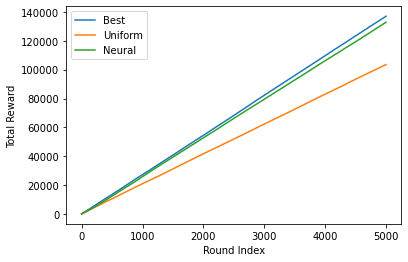

In [9]:
import matplotlib.pyplot as plt
h_r_b = bestagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = neuralagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

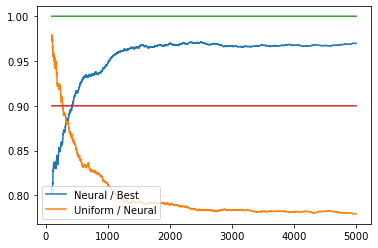

In [10]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural"])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.plot(range(100, T), 0.9 * np.ones(T)[100:T])